In [25]:
from sklearn.metrics import f1_score
import numpy as np

# Find the majority class in the training set
majority_class = y_train.mode()[0]

# Predict the majority class for all test samples
y_pred_majority = np.full_like(y_test, majority_class)

# Calculate F1 score
baseline_f1_majority = f1_score(y_test, y_pred_majority, average='weighted')

print(f"Baseline F1 Score (Majority Class): {baseline_f1_majority:.4f}")


Baseline F1 Score (Majority Class): 0.1138


In [21]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd


file_path = 'data/personality.csv' 
df = pd.read_csv(file_path, header=0) 
X = df.drop(columns='Personality')
y = df['Personality']


categorical_features = ['Gender', 'Interest']
numerical_features = ['Age', 'Introversion Score', 'Sensing Score', 
                      'Thinking Score', 'Judging Score', 'Education']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),   
        ('num', StandardScaler(), numerical_features)     
    ]
)


ML_algo = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

def MLpipe_StratifiedKFold_WeightedF1(X, y, preprocessor, ML_algo, param_grid):
   
    test_scores = []
    best_models = []
    accuracy_scores = [] 

    for random_state in range(42): 
      
        strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
        for train_index, test_index in strat_split.split(X, y):
            X_other, X_test = X.iloc[train_index], X.iloc[test_index]
            y_other, y_test = y.iloc[train_index], y.iloc[test_index]

       
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', ML_algo)])

      
        kf = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=random_state)
        grid_search = GridSearchCV(
            pipeline,
            param_grid={'model__' + key: val for key, val in param_grid.items()},
            cv=kf,
            scoring='f1_weighted',
            n_jobs=-1
        )
        
       
        grid_search.fit(X_other, y_other)

      
        best_model = grid_search.best_estimator_
        y_test_pred = best_model.predict(X_test)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        
      
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
  
        print("Best Model Parameters:", grid_search.best_params_)
      
        test_scores.append(test_f1)
        best_models.append(best_model)
        accuracy_scores.append(test_accuracy)

  
    print(f"Mean Test Weighted F1 Score: {np.mean(test_scores):.4f}")
    print(f"Standard Deviation of Test Weighted F1 Score: {np.std(test_scores):.4f}")
    print(f"Mean Test Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Standard Deviation of Test Accuracy: {np.std(accuracy_scores):.4f}")

    return test_scores, best_models


test_scores, best_models = MLpipe_StratifiedKFold_WeightedF1(X, y, preprocessor, ML_algo, param_grid)


Best Model Parameters: {'model__max_depth': 20, 'model__n_estimators': 200}
Best Model Parameters: {'model__max_depth': 20, 'model__n_estimators': 200}
Best Model Parameters: {'model__max_depth': 20, 'model__n_estimators': 200}
Best Model Parameters: {'model__max_depth': 20, 'model__n_estimators': 200}
Best Model Parameters: {'model__max_depth': 20, 'model__n_estimators': 200}
Mean Test Weighted F1 Score: 0.9051
Standard Deviation of Test Weighted F1 Score: 0.0009
Mean Test Accuracy: 0.9053
Standard Deviation of Test Accuracy: 0.0009


In [22]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd


label_encoder = LabelEncoder()
y_encoded = pd.Series(label_encoder.fit_transform(y))  


model = LogisticRegression(solver='lbfgs', max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
}
print('=========================Multinomial Logistic Regression=========================')
test_scores, best_models = MLpipe_StratifiedKFold_WeightedF1(X, y_encoded, preprocessor, model, param_grid)


model = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'n_estimators': [50, 100, 200],    
    'learning_rate': [0.01, 0.1, 0.2],
}
print('=========================XGBoost=========================')
test_scores, best_models = MLpipe_StratifiedKFold_WeightedF1(X, y_encoded, preprocessor, model, param_grid)


model = SVC()
param_grid = {
    'kernel': ['linear', 'rbf'], 
    'C': [0.01, 0.1, 1, 10, 100], 
}
print('=========================Support Vector Machine=========================')
test_scores, best_models = MLpipe_StratifiedKFold_WeightedF1(X, y_encoded, preprocessor, model, param_grid)

# K近邻分类器
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 10, 15],   
    'weights': ['uniform', 'distance'], 
}
print('=========================K-Nearest Neighbor=========================')
test_scores, best_models = MLpipe_StratifiedKFold_WeightedF1(X, y_encoded, preprocessor, model, param_grid)


=========================Multinomial Logistic Regression=========================
Best Model Parameters: {'model__C': 100}
Best Model Parameters: {'model__C': 100}
Best Model Parameters: {'model__C': 100}
Best Model Parameters: {'model__C': 100}
Best Model Parameters: {'model__C': 100}
Mean Test Weighted F1 Score: 0.8611
Standard Deviation of Test Weighted F1 Score: 0.0013
Mean Test Accuracy: 0.8641
Standard Deviation of Test Accuracy: 0.0013
=========================XGBoost=========================
Best Model Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best Model Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best Model Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best Model Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best Model Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'mo

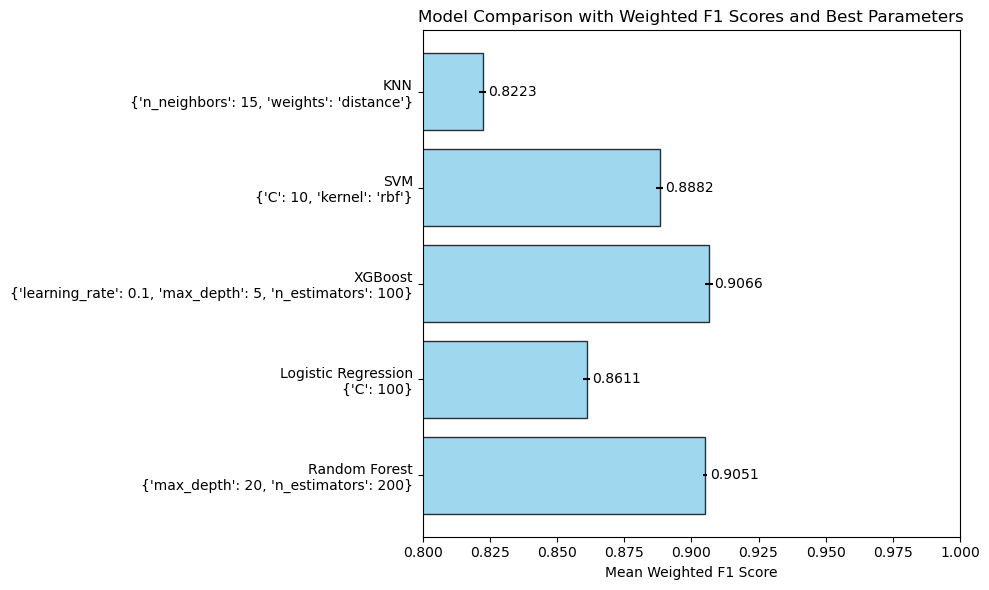

In [32]:
import matplotlib.pyplot as plt

# Model results
models = [
    "Random Forest\n{'max_depth': 20, 'n_estimators': 200}",
    "Logistic Regression\n{'C': 100}",
    "XGBoost\n{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}",
    "SVM\n{'C': 10, 'kernel': 'rbf'}",
    "KNN\n{'n_neighbors': 15, 'weights': 'distance'}"
]

f1_scores = [0.9051, 0.8611, 0.9066, 0.8882, 0.8223]
std_devs = [0.0009, 0.0013, 0.0014, 0.0013, 0.0012]

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(models, f1_scores, xerr=std_devs, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Mean Weighted F1 Score")
plt.title("Model Comparison with Weighted F1 Scores and Best Parameters")
plt.xlim(0.8, 1.0)

# Add F1 scores as text
for i, v in enumerate(f1_scores):
    plt.text(v + 0.002, i, f"{v:.4f}", va='center', fontsize=10)

plt.tight_layout()
plt.savefig("Model Comparison with Weighted F1 Scores and Best Parameters", dpi=300, bbox_inches='tight')
plt.show()


Best Model Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Test Weighted F1 Score: 0.9061
Test Accuracy: 0.9064


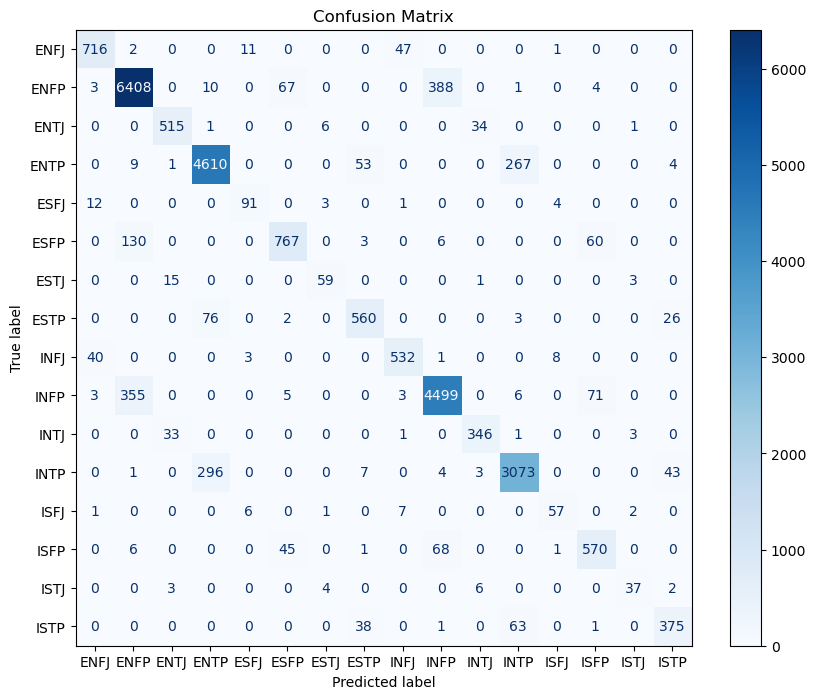

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd


file_path = 'data/personality.csv' 
df = pd.read_csv(file_path, header=0) 
X = df.drop(columns='Personality')
y = df['Personality']


categorical_features = ['Gender', 'Interest']
numerical_features = ['Age', 'Introversion Score', 'Sensing Score', 
                      'Thinking Score', 'Judging Score', 'Education']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),   
        ('num', StandardScaler(), numerical_features)     
    ]
)


label_encoder = LabelEncoder()
y_encoded = pd.Series(label_encoder.fit_transform(y))


model = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [5],
    'n_estimators': [100],
    'learning_rate': [0.1]
}


model = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [5],
    'n_estimators': [100],
    'learning_rate': [0.1]
}

def MLpipe_SingleRun(X, y, preprocessor, ML_algo, param_grid):
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in strat_split.split(X, y):
        X_other, X_test = X.iloc[train_index], X.iloc[test_index]
        y_other, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', ML_algo)])

    kf = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        param_grid={'model__' + key: val for key, val in param_grid.items()},
        cv=kf,
        scoring='f1_weighted',
        n_jobs=-1
    )

    grid_search.fit(X_other, y_other)

    best_model = grid_search.best_estimator_
    y_test_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred, labels=best_model.named_steps['model'].classes_)

    print(f"Best Model Parameters: {grid_search.best_params_}")
    print(f"Test Weighted F1 Score: {test_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Plot the confusion matrix with larger figure size
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.savefig("Confusion Matrix", dpi=300, bbox_inches='tight')
    plt.show()


MLpipe_SingleRun(X, y_encoded, preprocessor, model, param_grid)

D:\anaconda\envs\data1030\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:06:52] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


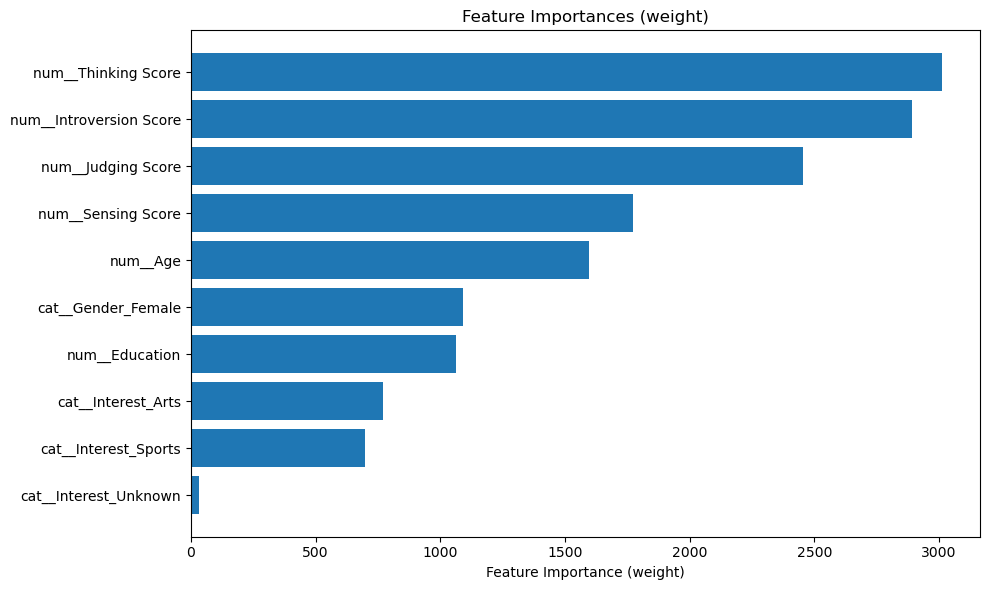

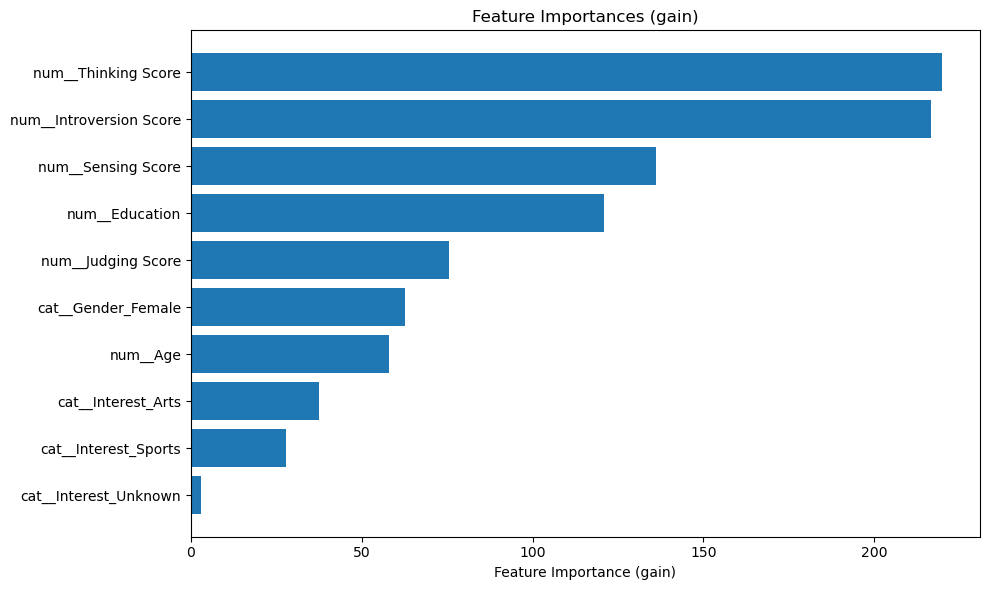

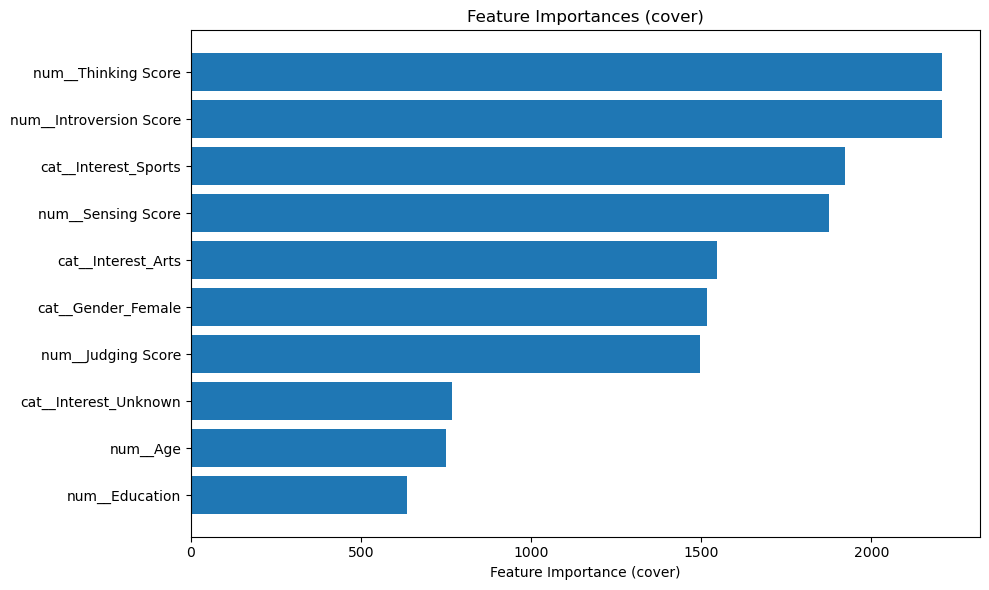

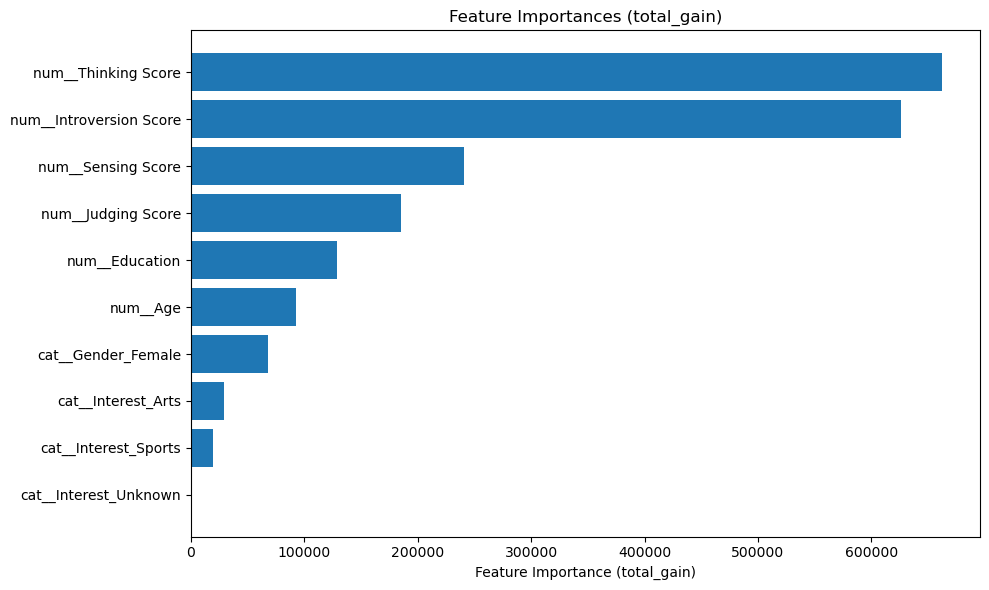

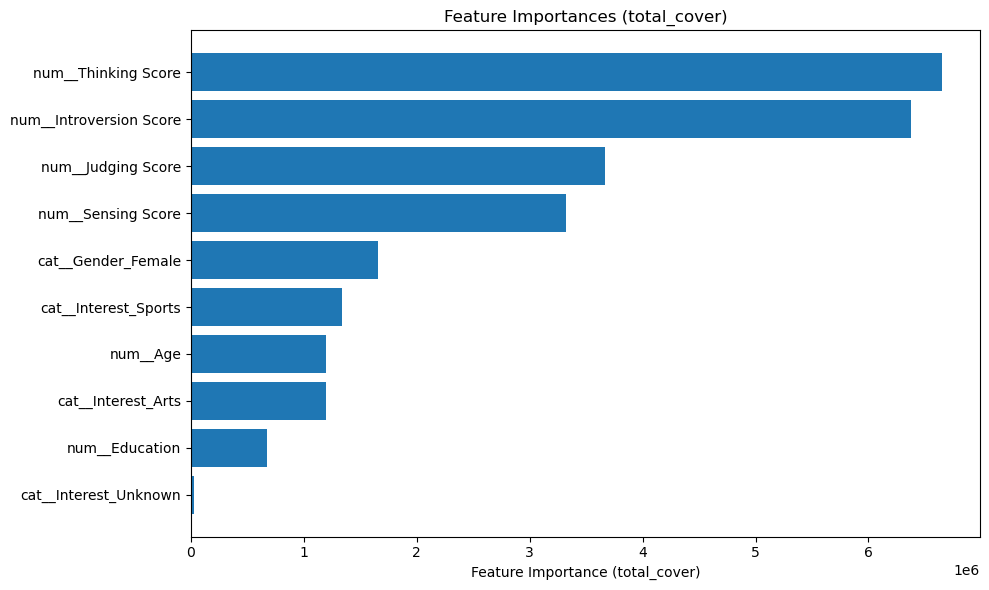

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline


file_path = 'data/personality.csv'  # Ensure the file path is correct
df = pd.read_csv(file_path, header=0)


X = df.drop(columns='Personality')
y = df['Personality']


categorical_features = ['Gender', 'Interest']
numerical_features = ['Age', 'Introversion Score', 'Sensing Score', 
                      'Thinking Score', 'Judging Score', 'Education']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


label_encoder = LabelEncoder()
y_encoded = pd.Series(label_encoder.fit_transform(y))


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}


strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in strat_split.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded.iloc[train_index], y_encoded.iloc[test_index]


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
kf = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid={'model__' + key: val for key, val in param_grid.items()},
    cv=kf,
    scoring='f1_weighted',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_


booster = best_pipeline.named_steps['model'].get_booster()


feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_map = {f'f{idx}': name for idx, name in enumerate(feature_names)}


importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for imp_type in importance_types:
   
    importance = booster.get_score(importance_type=imp_type)

   
    importance_df = pd.DataFrame({
        'Feature': [feature_map.get(f, f) for f in importance.keys()],
        'Importance': list(importance.values())
    })

    
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

 
    top_10 = importance_df.head(10)

   
    plt.figure(figsize=(10, 6))
    plt.barh(top_10['Feature'][::-1], top_10['Importance'][::-1])
    plt.xlabel(f'Feature Importance ({imp_type})')
    plt.title(f'Feature Importances ({imp_type})')
    plt.tight_layout()
    plt.savefig(f'Feature_Importance_{imp_type}.png', dpi=300, bbox_inches='tight')
    plt.show()


SHAP values shape: (25613, 16, 14)


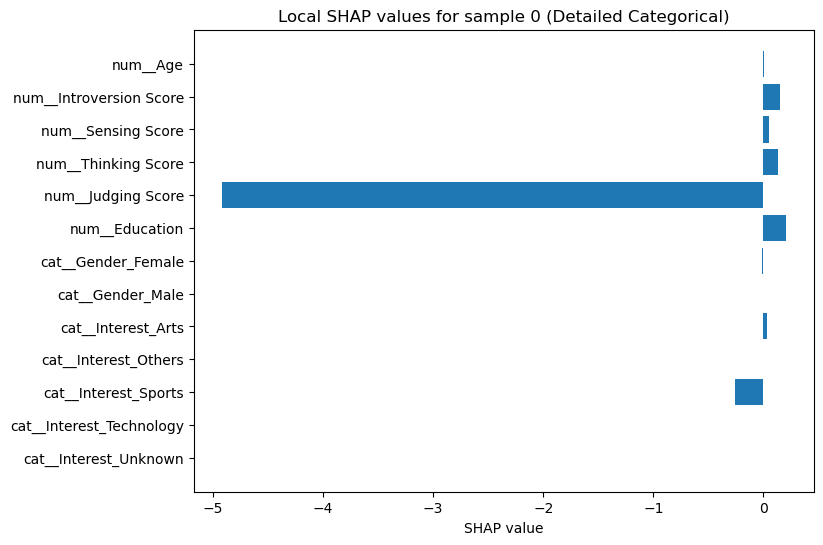

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import scipy


file_path = 'data/personality.csv'  
df = pd.read_csv(file_path, header=0)


X = df.drop(columns='Personality')
y = df['Personality']


categorical_features = ['Gender', 'Interest']
numerical_features = ['Age', 'Introversion Score', 'Sensing Score', 
                      'Thinking Score', 'Judging Score', 'Education']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


label_encoder = LabelEncoder()
y_encoded = pd.Series(label_encoder.fit_transform(y))


model = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}


strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in strat_split.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded.iloc[train_index], y_encoded.iloc[test_index]


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
kf = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid={'model__' + key: val for key, val in param_grid.items()},
    cv=kf,
    scoring='f1_weighted',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_


final_preprocessor = best_pipeline.named_steps['preprocessor']
final_model = best_pipeline.named_steps['model']


X_test_transformed = final_preprocessor.transform(X_test)


if scipy.sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()


booster = final_model.get_booster()
dtest = DMatrix(X_test_transformed)
shap_values = booster.predict(dtest, pred_contribs=True)

print("SHAP values shape:", shap_values.shape)



feature_names = final_preprocessor.get_feature_names_out()


if len(shap_values.shape) == 3:
    # Multiclass case
    class_idx = 0 
    shap_values_for_class = shap_values[:, class_idx, :-1]
else:
    
    shap_values_for_class = shap_values[:, :-1]


i = 0
local_shap = shap_values_for_class[i]


cat_mask = np.array(["cat__" in fname for fname in feature_names])


cat_shap_values = local_shap[cat_mask]
cat_feature_names = feature_names[cat_mask]


numeric_shap = local_shap[~cat_mask]
numeric_feature_names = feature_names[~cat_mask]


combined_feature_names = list(numeric_feature_names) + list(cat_feature_names)
combined_shap_values = np.concatenate([numeric_shap, cat_shap_values])


plt.figure(figsize=(8, 6))
plt.barh(range(len(combined_feature_names)), combined_shap_values)
plt.yticks(range(len(combined_feature_names)), combined_feature_names)
plt.xlabel("SHAP value")
plt.title(f"Local SHAP values for sample {i} (Detailed Categorical)")
plt.gca().invert_yaxis()  # Place the most important feature at the top
plt.savefig(f"Local_SHAP_values_sample_{i}.png", dpi=300, bbox_inches='tight')
plt.show()
